# Predict  The Qatar World Cup 2022 Winner with Python
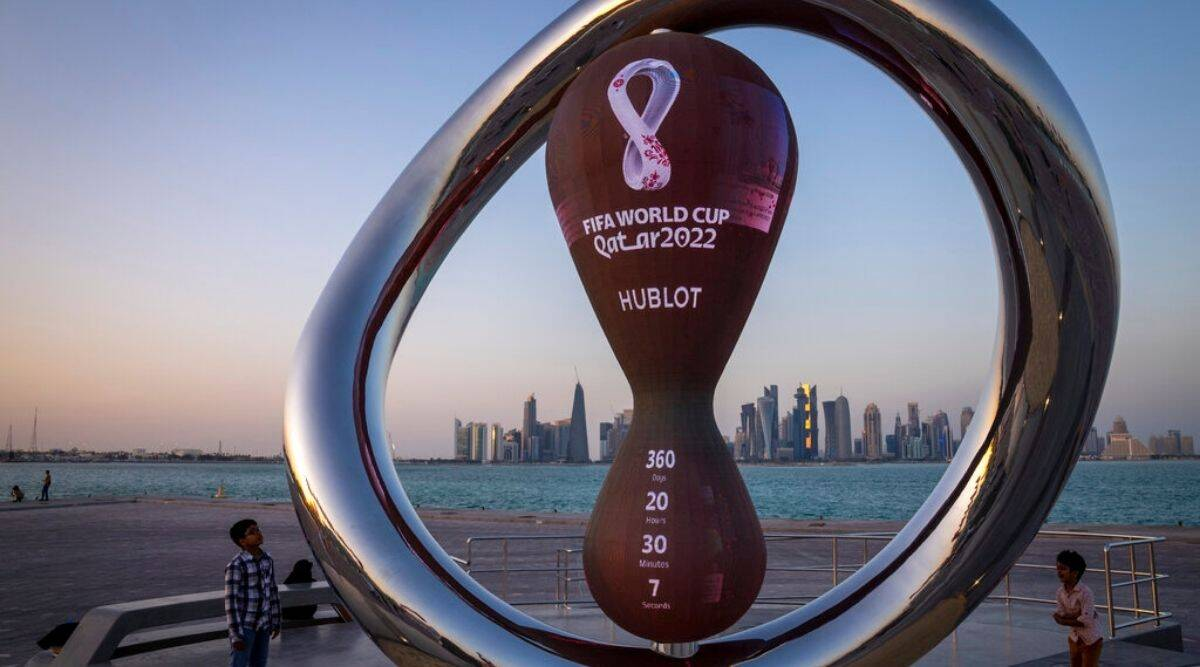

In [1]:
# Loading requried libraries
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
import pickle
from scipy.stats import poisson

In [2]:
dict_table=pickle.load(open("C:\\Users\\Pranav\\Desktop\\DATA SCIENCE DATA\\CVC file\\Qutar fifa world cup\\dict_table",'rb'))
fifa_historical_data=pd.read_csv("C:\\Users\\Pranav\\Desktop\\DATA SCIENCE DATA\\CVC file\\Qutar fifa world cup\\clean_fifa_worldcup_matches.csv")
fifa_fixture=pd.read_csv("C:\\Users\\Pranav\\Desktop\\DATA SCIENCE DATA\\CVC file\\Qutar fifa world cup\\clean_fifa_worldcup_fixture.csv")

In [3]:
dict_table['Group A']

,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
0,1,Qatar (H),0,0,0,0,0,0,0,0
1,2,Ecuador,0,0,0,0,0,0,0,0
2,3,Senegal,0,0,0,0,0,0,0,0
3,4,Netherlands,0,0,0,0,0,0,0,0


In [4]:
fifa_historical_data.head()

,HomeTeam,AwayTeam,Year,HomeGoals,AwayGoals,TotalGoals
0,France,Mexico,1930,4,1,5
1,Uruguay,Argentina,1930,4,2,6
2,Uruguay,Yugoslavia,1930,6,1,7
3,Argentina,United States,1930,6,1,7
4,Paraguay,Belgium,1930,1,0,1


In [5]:
fifa_fixture.head()

,home,score,away,year
0,Qatar,Match 1,Ecuador,2022
1,Senegal,Match 2,Netherlands,2022
2,Qatar,Match 18,Senegal,2022
3,Netherlands,Match 19,Ecuador,2022
4,Ecuador,Match 35,Senegal,2022


In [6]:
# shape of dataset
fifa_historical_data.shape

(900, 6)

In [7]:
# shape of dataset
fifa_fixture.shape

(64, 4)

In [8]:
# information about dataset
fifa_historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   HomeTeam    900 non-null    object
 1   AwayTeam    900 non-null    object
 2   Year        900 non-null    int64 
 3   HomeGoals   900 non-null    int64 
 4   AwayGoals   900 non-null    int64 
 5   TotalGoals  900 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 42.3+ KB


In [9]:
# information about dataset
fifa_fixture.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   home    64 non-null     object
 1   score   64 non-null     object
 2   away    64 non-null     object
 3   year    64 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 2.1+ KB


In [10]:
#Describe of dataset
fifa_historical_data.describe()

,Year,HomeGoals,AwayGoals,TotalGoals
count,900.000000,900.000000,900.000000,900.000000
mean,1986.915556,1.763333,1.067778,2.831111
std,23.150270,1.605950,1.082198,1.930474
min,1930.000000,0.000000,0.000000,0.000000
25%,1970.000000,1.000000,0.000000,1.000000
50%,1990.000000,1.000000,1.000000,3.000000
75%,2006.000000,3.000000,2.000000,4.000000
max,2018.000000,10.000000,7.000000,12.000000


In [11]:
#Describe of dataset
fifa_fixture.describe()

,year
count,64.0
mean,2022.0
std,0.0
min,2022.0
25%,2022.0
50%,2022.0
75%,2022.0
max,2022.0


In [12]:
# find ot null value in dataset
fifa_historical_data.isnull().sum()

HomeTeam      0
AwayTeam      0
Year          0
HomeGoals     0
AwayGoals     0
TotalGoals    0
dtype: int64

In [13]:
# find ot null value in dataset
fifa_fixture.isnull().sum()

home     0
score    0
away     0
year     0
dtype: int64

In [14]:
# index of dataset
fifa_historical_data.index

RangeIndex(start=0, stop=900, step=1)

In [15]:
# index of dataset
fifa_fixture.index

RangeIndex(start=0, stop=64, step=1)

In [16]:
 # Dtypes of dataset
fifa_historical_data.dtypes

HomeTeam      object
AwayTeam      object
Year           int64
HomeGoals      int64
AwayGoals      int64
TotalGoals     int64
dtype: object

In [17]:
 # Dtypes of dataset
fifa_fixture.dtypes

home     object
score    object
away     object
year      int64
dtype: object

## 1. Calculate Team Strength

In [18]:
# split data into df_home and df_away
df_home=fifa_historical_data[['HomeTeam','HomeGoals','AwayGoals']]
df_away=fifa_historical_data[['AwayTeam','HomeGoals','AwayGoals']]

In [25]:
# Rename column
df_home = df_home.rename(columns={'HomeTeam':'Team', 'HomeGoals': 'GoalsScored', 'AwayGoals': 'GoalsConceded'})
df_away = df_away.rename(columns={'AwayTeam':'Team', 'HomeGoals': 'GoalsConceded', 'AwayGoals': 'GoalsScored'})

In [26]:
# Concat df_home df_away , group by team and calculate the mean
df_team_strength = pd.concat([df_home, df_away], ignore_index=True).groupby(['Team']).mean()
df_team_strength

,GoalsScored,GoalsConceded
Team,,
Algeria,1.000000,1.461538
Angola,0.333333,0.666667
Argentina,1.691358,1.148148
Australia,0.812500,1.937500
Austria,1.482759,1.620690
...,...,...
Uruguay,1.553571,1.321429
Wales,0.800000,0.800000
West Germany,2.112903,1.241935


## Function predict_points

In [27]:
def predict_points(home, away):
    if home in df_team_strength.index and away in df_team_strength.index:
        # goals_scored * goals_conceded
        lamb_home = df_team_strength.at[home,'GoalsScored'] * df_team_strength.at[away,'GoalsConceded']
        lamb_away = df_team_strength.at[away,'GoalsScored'] * df_team_strength.at[home,'GoalsConceded']
        prob_home, prob_away, prob_draw = 0, 0, 0
        for x in range(0,11): #number of goals home team
            for y in range(0, 11): #number of goals away team
                p = poisson.pmf(x, lamb_home) * poisson.pmf(y, lamb_away)
                if x == y:
                    prob_draw += p
                elif x > y:
                    prob_home += p
                else:
                    prob_away += p
        
        points_home = 3 * prob_home + prob_draw
        points_away = 3 * prob_away + prob_draw
        return (points_home, points_away)
    else:
        return (0, 0)

## Testing the function

In [28]:
# Qatar vs Team X -> 0 points to both
print(predict_points('England', 'United States'))
print(predict_points('Argentina', 'Mexico'))
print(predict_points('Qatar (H)', 'Ecuador'))

(2.2356147635326007, 0.5922397535606193)
(2.3129151525530505, 0.5378377125059863)
(0, 0)


## Predicting World Cup
### Group stage

In [30]:
df_fixture_group_48 = fifa_fixture[:48].copy()
df_fixture_knockout = fifa_fixture[48:56].copy()
df_fixture_quarter = fifa_fixture[56:60].copy()
df_fixture_semi = fifa_fixture[60:62].copy()
df_fixture_final = fifa_fixture[62:].copy()

In [31]:
for group in dict_table:
    teams_in_group = dict_table[group]['Team'].values
    df_fixture_group_6 = df_fixture_group_48[df_fixture_group_48['home'].isin(teams_in_group)]
    for index, row in df_fixture_group_6.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)
        dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts'] += points_home
        dict_table[group].loc[dict_table[group]['Team'] == away, 'Pts'] += points_away

    dict_table[group] = dict_table[group].sort_values('Pts', ascending=False).reset_index()
    dict_table[group] = dict_table[group][['Team', 'Pts']]
    dict_table[group] = dict_table[group].round(0)

In [32]:
dict_table['Group A']

,Team,Pts
0,Netherlands,4.0
1,Senegal,2.0
2,Ecuador,2.0
3,Qatar (H),0.0


# Knock out

In [34]:
df_fixture_knockout

,home,score,away,year
48,Winners Group A,Match 49,Runners-up Group B,2022
49,Winners Group C,Match 50,Runners-up Group D,2022
50,Winners Group D,Match 52,Runners-up Group C,2022
51,Winners Group B,Match 51,Runners-up Group A,2022
52,Winners Group E,Match 53,Runners-up Group F,2022
53,Winners Group G,Match 54,Runners-up Group H,2022
54,Winners Group F,Match 55,Runners-up Group E,2022
55,Winners Group H,Match 56,Runners-up Group G,2022


In [35]:
for group in dict_table:
    group_winner = dict_table[group].loc[0, 'Team']
    runners_up = dict_table[group].loc[1, 'Team']
    df_fixture_knockout.replace({f'Winners {group}':group_winner,
                                 f'Runners-up {group}':runners_up}, inplace=True)

df_fixture_knockout['winner'] = '?'
df_fixture_knockout

,home,score,away,year,winner
48,Netherlands,Match 49,Wales,2022,?
49,Argentina,Match 50,Denmark,2022,?
50,France,Match 52,Poland,2022,?
51,England,Match 51,Senegal,2022,?
52,Germany,Match 53,Belgium,2022,?
53,Brazil,Match 54,Uruguay,2022,?
54,Croatia,Match 55,Spain,2022,?
55,Portugal,Match 56,Switzerland,2022,?


In [36]:
def get_winner(df_fixture_updated):
    for index, row in df_fixture_updated.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)
        if points_home > points_away:
            winner = home
        else:
            winner = away
        df_fixture_updated.loc[index, 'winner'] = winner
    return df_fixture_updated

In [37]:
get_winner(df_fixture_knockout)

,home,score,away,year,winner
48,Netherlands,Match 49,Wales,2022,Netherlands
49,Argentina,Match 50,Denmark,2022,Argentina
50,France,Match 52,Poland,2022,France
51,England,Match 51,Senegal,2022,England
52,Germany,Match 53,Belgium,2022,Germany
53,Brazil,Match 54,Uruguay,2022,Brazil
54,Croatia,Match 55,Spain,2022,Spain
55,Portugal,Match 56,Switzerland,2022,Portugal


# Quarter Final

In [38]:
def update_table(df_fixture_round_1, df_fixture_round_2):
    for index, row in df_fixture_round_1.iterrows():
        winner = df_fixture_round_1.loc[index, 'winner']
        match = df_fixture_round_1.loc[index, 'score']
        df_fixture_round_2.replace({f'Winners {match}':winner}, inplace=True)
    df_fixture_round_2['winner'] = '?'
    return df_fixture_round_2

In [39]:
update_table(df_fixture_knockout, df_fixture_quarter)

,home,score,away,year,winner
56,Germany,Match 58,Brazil,2022,?
57,Netherlands,Match 57,Argentina,2022,?
58,Spain,Match 60,Portugal,2022,?
59,England,Match 59,France,2022,?


In [40]:
get_winner(df_fixture_quarter)

,home,score,away,year,winner
56,Germany,Match 58,Brazil,2022,Brazil
57,Netherlands,Match 57,Argentina,2022,Netherlands
58,Spain,Match 60,Portugal,2022,Portugal
59,England,Match 59,France,2022,France


# Semifinal

In [41]:
update_table(df_fixture_quarter, df_fixture_semi)

,home,score,away,year,winner
60,Netherlands,Match 61,Brazil,2022,?
61,France,Match 62,Portugal,2022,?


In [42]:
get_winner(df_fixture_semi)

,home,score,away,year,winner
60,Netherlands,Match 61,Brazil,2022,Brazil
61,France,Match 62,Portugal,2022,France


# Final

In [43]:
update_table(df_fixture_semi, df_fixture_final)

,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,?
63,Brazil,Match 64,France,2022,?


In [44]:
get_winner(df_fixture_final)

,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,Losers Match 62
63,Brazil,Match 64,France,2022,Brazil
